# 1. Mean Reversion

In [1]:
# import libraries
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import pyfolio as pf
import datetime
import warnings
warnings.filterwarnings('ignore')

c:\Users\ezlik\anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
class MeanReversion():

    def __init__(self, symbol, period, start, end=datetime.datetime.now()):
        self.symbol = symbol
        self.period = period
        self.start = start
        self.end = end
        self.get_data()
    
    def get_data(self):

        # extract data
        data = yf.download(self.symbol, start=self.start, end=self.end).loc[:, "Close"].to_frame()

        # calculate rolling mean and standard deviation
        data["rolling_mean"] = data["Close"].rolling(window=self.period).mean()
        data["rolling_std"] = data["Close"].rolling(window=self.period).std()

        # calculate Z-score
        data["Z_score"] = (data["Close"] - data["rolling_mean"]) / data["rolling_std"]

        # define entry and exit points
        entry_threshold = -1.0
        exit_threshold = 0.5

        # generate buy and sell signals
        buysignals = data[data["Z_score"] < entry_threshold]
        sellsignals = data[data["Z_score"] > exit_threshold]

        # position
        data["position"] = np.where(data["Z_score"] < entry_threshold, 1, -1)

        # buy and hold strategy
        data["buy_and_hold"] = np.log(data["Close"] / data["Close"].shift(1))

        # strategy returns
        data["strategy"] = data["position"].shift(1) * data["buy_and_hold"]

        # drop na
        data.dropna(inplace=True)

        # set date as index
        data.reset_index(inplace=True)
        data.set_index('Date', inplace=True)

        # assign to self
        self.data = data
        self.buysignals = buysignals
        self.sellsignals = sellsignals

        return data, buysignals, sellsignals    
    
    def performance_summary(self):

        # calculate sum of buy_and_hold
        # calculate sum
        print("Sum of buy_and_hold:")
        print(self.data[["buy_and_hold", "strategy"]].sum(), "\n")
        print("#" * 50)

        # calculate what $1 would be worth
        print("What $1 would be worth:")
        print(self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp), "\n")
        print("#" * 50)

        # calculate performance metrics
        print("Performance metrics:")
        pf.show_perf_stats(self.data["strategy"])
        print("#" * 50)

        # Plot graph
        self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp).plot(figsize=(10, 8))
        plt.legend(loc="upper left")
        plt.title(f"{self.symbol} Mean Reversion of {self.period} days")
        plt.ylabel("Price (USD)")
        plt.xlabel("Date")

        # plot buy and sell signals
        self.data[["Close"]].plot(figsize=(10, 8), color="gray", zorder=1)
        plt.title(f"Buy and Sell signals of {self.symbol}")
        plt.ylabel("Price (USD)")
        plt.xlabel("Date")

        plt.scatter(self.buysignals.index, self.buysignals["Close"], marker="^", color="green")
        plt.scatter(self.sellsignals.index, self.sellsignals["Close"], marker="v", color="red")               

        plt.legend()
        plt.show()

In [11]:
# Create an empty DataFrame to store the performance statistics
compiled_data = pd.DataFrame()

sp500_tickers = ["AAPL", "AMD", "MSFT", "AMZN", "GOOGL", "JPM", "META", "TSLA", "V", "JNJ",
    "PG", "NVDA", "MA", "HD", "UNH", "VZ", "NFLX", "DIS", "PYPL", "ADBE"]

# Loop through the ticker symbols
for ticker_symbol in sp500_tickers:

    # Instantiate the strategy class with the current ticker symbol
    ticker = MeanReversion(symbol=ticker_symbol, period=12, start="2022-01-01", end=datetime.datetime.now().date())
    
    # Calculate performance statistics for the strategy
    performance_stats = pf.timeseries.perf_stats(ticker.data["strategy"])
    
    # Create a new row as a DataFrame with the ticker symbol as the index
    new_row = pd.DataFrame([performance_stats], index=[ticker_symbol])
    
    # Concatenate the new row to the compiled_data DataFrame
    compiled_data = pd.concat([compiled_data, new_row], axis=0)

# Rename the columns of the compiled_data DataFrame
compiled_data.columns = [col for col in compiled_data.columns]

# sort the index
compiled_data.sort_index(inplace=True)

# Add average values to the compiled_data DataFrame
average_row = compiled_data.mean()

# Create a new row as a DataFrame
average_row = pd.DataFrame([average_row], index=["average"])

# Concatenate the average_row to the DataFrame
compiled_data = pd.concat([compiled_data, average_row], axis=0)

# round the values
compiled_data = compiled_data.round(3)

# Print the compiled_data DataFrame
compiled_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,Annual return,Cumulative returns,Annual volatility,Sharpe ratio,Calmar ratio,Stability,Max drawdown,Omega ratio,Sortino ratio,Skew,Kurtosis,Tail ratio,Daily value at risk
AAPL,0.191,0.361,0.301,0.729,0.502,0.158,-0.380,1.131,1.133,0.402,1.585,1.301,-0.037
ADBE,-0.064,-0.110,0.404,0.036,-0.121,0.327,-0.524,1.006,0.055,0.865,6.600,1.032,-0.051
AMD,-0.078,-0.134,0.556,0.131,-0.130,0.392,-0.601,1.022,0.187,0.012,1.316,1.047,-0.070
AMZN,0.151,0.281,0.442,0.536,0.450,0.182,-0.335,1.096,0.810,0.550,3.328,1.085,-0.055
DIS,-0.104,-0.177,0.334,-0.162,-0.227,0.126,-0.460,0.973,-0.219,-0.610,4.742,0.995,-0.042
GOOGL,0.410,0.834,0.360,1.135,1.421,0.538,-0.289,1.211,1.748,0.284,1.783,1.026,-0.044
HD,0.173,0.326,0.274,0.721,0.901,0.708,-0.192,1.132,1.052,-0.190,3.697,1.001,-0.034
JNJ,0.027,0.048,0.172,0.240,0.131,0.427,-0.206,1.042,0.354,0.075,3.516,1.163,-0.021
JPM,-0.001,-0.001,0.260,0.127,-0.004,0.258,-0.216,1.022,0.176,-0.287,1.666,0.904,-0.033
MA,-0.261,-0.414,0.265,-1.007,-0.570,0.904,-0.458,0.840,-1.312,-0.498,2.609,0.911,-0.035


In [45]:
# Export to excel
compiled_data.to_csv('compiled_data_mean_rever.csv')

,Annual return,Cumulative returns,Annual volatility,Sharpe ratio,Calmar ratio,Stability,Max drawdown,Omega ratio,Sortino ratio,Skew,Kurtosis,Tail ratio,Daily value at risk
AAPL,0.104,0.448,0.344,0.458,0.196,0.310,-0.532,1.085,0.711,0.706,4.566,1.188,-0.043
ADBE,-0.040,-0.142,0.404,0.097,-0.064,0.000,-0.626,1.018,0.151,1.033,7.275,1.167,-0.051
AMD,0.039,0.153,0.542,0.341,0.059,0.030,-0.653,1.060,0.490,0.007,2.036,1.026,-0.068
AMZN,0.066,0.271,0.383,0.358,0.137,0.590,-0.482,1.064,0.529,0.419,3.680,0.971,-0.048
DIS,-0.091,-0.300,0.364,-0.079,-0.141,0.709,-0.646,0.985,-0.109,-0.290,7.085,0.949,-0.046
GOOGL,0.094,0.398,0.339,0.433,0.180,0.303,-0.522,1.079,0.640,0.210,3.006,1.072,-0.042
HD,-0.187,-0.538,0.316,-0.491,-0.253,0.435,-0.739,0.910,-0.635,-1.858,20.514,1.019,-0.040
JNJ,-0.002,-0.006,0.210,0.097,-0.004,0.088,-0.421,1.019,0.142,0.249,7.796,1.085,-0.026
JPM,0.022,0.083,0.353,0.236,0.045,0.161,-0.477,1.046,0.343,0.440,10.888,0.903,-0.044
MA,-0.027,-0.097,0.344,0.092,-0.053,0.382,-0.512,1.017,0.133,0.305,7.555,1.054,-0.043


[*********************100%***********************]  1 of 1 completed
Sum of buy_and_hold:
buy_and_hold    0.829854
strategy        0.589260
dtype: float64 

##################################################
What $1 would be worth:
            buy_and_hold  strategy
Date                              
2020-01-17      1.011071  0.989050
2020-01-21      1.004219  0.995799
2020-01-22      1.007804  0.992257
2020-01-23      1.012657  0.987501
2020-01-24      1.009739  0.990355
...                  ...       ...
2023-10-06      2.252126  1.835357
2023-10-09      2.271159  1.819976
2023-10-10      2.263545  1.826097
2023-10-11      2.281436  1.811777
2023-10-12      2.292983  1.802653

[941 rows x 2 columns] 

##################################################
Performance metrics:


Start date,2020-01-17
End date,2023-10-12
Total months,44
,Backtest
Annual return,10.4%
Cumulative returns,44.8%
Annual volatility,34.4%
Sharpe ratio,0.46
Calmar ratio,0.20
Stability,0.31
Max drawdown,-53.2%


##################################################


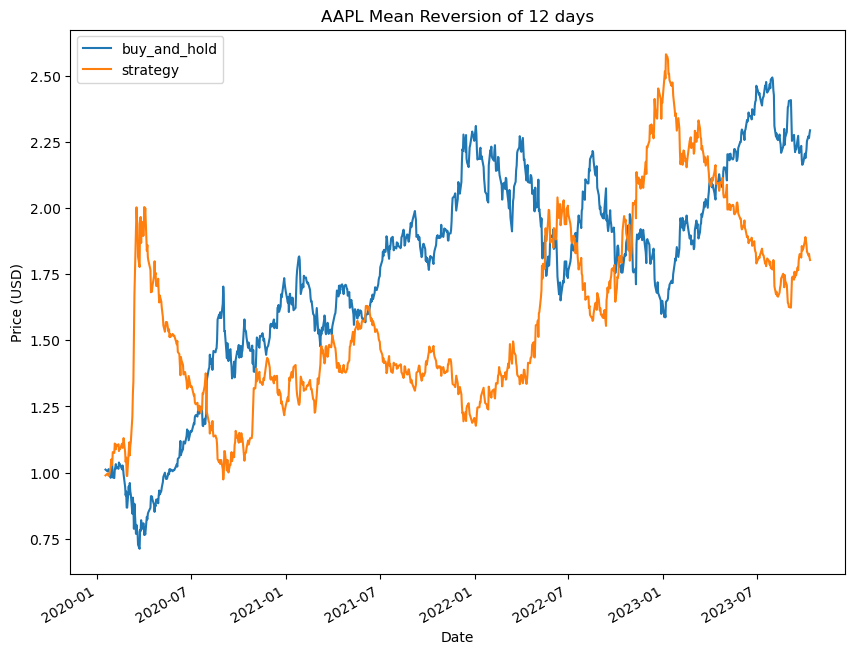

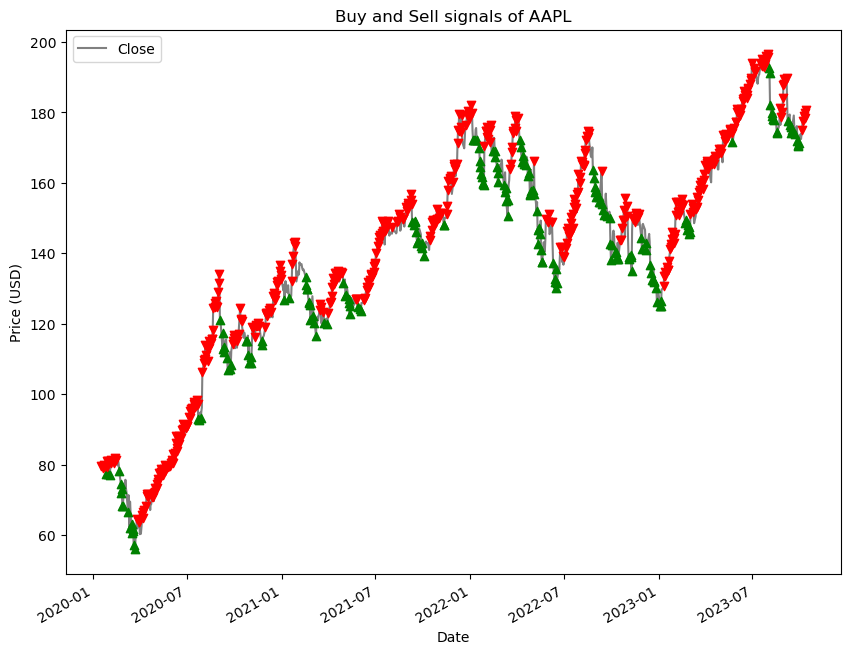

In [46]:
aapl = MeanReversion("AAPL", 12, "2020-01-01")
aapl.performance_summary()

# 2. Mean Reversion with Bollinger Bands

In [12]:
class MeanReversionBollinger():

    def __init__(self, symbol, period, start, end=datetime.datetime.now()):
        self.symbol = symbol
        self.period = period
        self.start = start
        self.end = end
        self.get_data()
    
    def get_data(self):

        # extract data
        data = yf.download(self.symbol, start=self.start, end=self.end).loc[:, "Close"].to_frame()

        # calculate middle band
        data["middle_band"] = data["Close"].rolling(window=self.period).mean()

        # calculate standard deviation
        data["rolling_std"] = data["Close"].rolling(window=self.period).std()

        # calculate upper and lower band
        num_std = 1.5
        data["upper_band"] = data["middle_band"] + (data["rolling_std"] * num_std)
        data["lower_band"] = data["middle_band"] - (data["rolling_std"] * num_std)

        # generate buy and sell signals
        buysignals = data[data["Close"] < data["lower_band"]]
        sellsignals = data[data["Close"] > data["upper_band"]]

        # position
        data["position"] = np.where(data["Close"] < data["lower_band"], 1, -1)

        # buy and hold strategy
        data["buy_and_hold"] = np.log(data["Close"] / data["Close"].shift(1))

        # strategy returns
        data["strategy"] = data["position"].shift(1) * data["buy_and_hold"]

        # drop na
        data.dropna(inplace=True)

        # set date as index
        data.reset_index(inplace=True)
        data.set_index('Date', inplace=True)

        # assign to self
        self.data = data
        self.buysignals = buysignals
        self.sellsignals = sellsignals

        return data, buysignals, sellsignals

    def performance_summary(self):

        # calculate sum of buy_and_hold
        # calculate sum
        print("Sum of returns:")
        print(self.data[["buy_and_hold", "strategy"]].sum(), "\n")
        print("#" * 50)

        # calculate what $1 would be worth
        print("What $1 would be worth:")
        print(self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp), "\n")
        print("#" * 50)

        # calculate performance metrics
        print("Performance metrics:")
        pf.show_perf_stats(self.data["strategy"])
        print("#" * 50)

        # Plot graph
        self.data[["Close", "middle_band", "upper_band", "lower_band"]].plot(figsize=(10, 8))
        plt.legend(loc="upper left")
        plt.title(f"{self.symbol} Mean Reversion with Bollinger Bands of {self.period} days")
        plt.ylabel("Price (USD)")
        plt.xlabel("Date")

        self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp).plot(figsize=(10, 8))
        plt.legend(loc="upper left")
        plt.title(f"{self.symbol} Mean Reversion with Bollinger Bands of {self.period} days")
        plt.ylabel("Price (USD)")
        plt.xlabel("Date")

        # plot buy and sell signals
        self.data[["Close"]].plot(figsize=(10, 8), color="gray", zorder=1)
        plt.title(f"Buy and Sell signals of {self.symbol}")
        plt.ylabel("Price (USD)")
        plt.xlabel("Date")

        plt.scatter(self.buysignals.index, self.buysignals["Close"], marker="^", color="green")
        plt.scatter(self.sellsignals.index, self.sellsignals["Close"], marker="v", color="red")               

        plt.legend()
        plt.show()

In [13]:
# Create an empty DataFrame to store the performance statistics
compiled_data = pd.DataFrame()

sp500_tickers = ["AAPL", "AMD", "MSFT", "AMZN", "GOOGL", "JPM", "META", "TSLA", "V", "JNJ",
    "PG", "NVDA", "MA", "HD", "UNH", "VZ", "NFLX", "DIS", "PYPL", "ADBE"]

# Loop through the ticker symbols
for ticker_symbol in sp500_tickers:

    # Instantiate the strategy class with the current ticker symbol
    ticker = MeanReversionBollinger(symbol=ticker_symbol, period=28, start="2022-01-01", end=datetime.datetime.now().date())
    
    # Calculate performance statistics for the strategy
    performance_stats = pf.timeseries.perf_stats(ticker.data["strategy"])
    
    # Create a new row as a DataFrame with the ticker symbol as the index
    new_row = pd.DataFrame([performance_stats], index=[ticker_symbol])
    
    # Concatenate the new row to the compiled_data DataFrame
    compiled_data = pd.concat([compiled_data, new_row], axis=0)

# Rename the columns of the compiled_data DataFrame
compiled_data.columns = [col for col in compiled_data.columns]

# sort the index
compiled_data.sort_index(inplace=True)

# Add average values to the compiled_data DataFrame
average_row = compiled_data.mean()

# Create a new row as a DataFrame
average_row = pd.DataFrame([average_row], index=["average"])

# Concatenate the average_row to the DataFrame
compiled_data = pd.concat([compiled_data, average_row], axis=0)

# round the values
compiled_data = compiled_data.round(3)

# Print the compiled_data DataFrame
compiled_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,Annual return,Cumulative returns,Annual volatility,Sharpe ratio,Calmar ratio,Stability,Max drawdown,Omega ratio,Sortino ratio,Skew,Kurtosis,Tail ratio,Daily value at risk
AAPL,0.454,0.892,0.299,1.401,1.225,0.301,-0.371,1.265,2.286,0.429,1.373,1.482,-0.036
ADBE,0.029,0.050,0.405,0.269,0.056,0.231,-0.515,1.048,0.421,1.064,6.753,1.084,-0.051
AMD,0.549,1.107,0.551,1.070,1.098,0.095,-0.500,1.195,1.600,0.019,1.444,1.111,-0.067
AMZN,0.208,0.380,0.428,0.654,0.462,0.012,-0.450,1.117,0.997,0.499,2.999,1.092,-0.053
DIS,0.365,0.698,0.331,1.104,1.251,0.612,-0.292,1.206,1.746,0.807,4.747,1.077,-0.040
GOOGL,0.458,0.900,0.357,1.234,1.322,0.272,-0.346,1.231,1.908,0.360,1.776,0.964,-0.043
HD,0.205,0.373,0.273,0.817,0.973,0.295,-0.210,1.151,1.278,0.500,3.724,1.069,-0.034
JNJ,0.020,0.034,0.173,0.200,0.092,0.000,-0.216,1.035,0.289,-0.095,3.551,1.169,-0.022
JPM,-0.170,-0.273,0.262,-0.583,-0.369,0.805,-0.462,0.906,-0.761,-0.571,1.604,0.860,-0.034
MA,-0.146,-0.235,0.257,-0.483,-0.385,0.749,-0.378,0.920,-0.677,0.050,1.729,1.011,-0.033


In [70]:
# Export to excel
compiled_data.to_csv('compiled_data_mean_rever_bollinger.csv')

,Annual return,Cumulative returns,Annual volatility,Sharpe ratio,Calmar ratio,Stability,Max drawdown,Omega ratio,Sortino ratio,Skew,Kurtosis,Tail ratio,Daily value at risk
AAPL,0.419,0.792,0.302,1.310,1.130,0.320,-0.371,1.245,2.134,0.439,1.318,1.466,-0.036
ADBE,-0.013,-0.021,0.407,0.168,-0.025,0.200,-0.515,1.030,0.262,1.078,6.745,1.107,-0.051
AMD,0.454,0.866,0.554,0.953,0.907,0.088,-0.500,1.172,1.417,0.029,1.432,1.110,-0.068
AMZN,0.154,0.269,0.429,0.546,0.342,0.015,-0.450,1.097,0.827,0.504,3.057,1.073,-0.053
DIS,0.338,0.624,0.333,1.038,1.157,0.588,-0.292,1.193,1.639,0.815,4.714,1.081,-0.041
GOOGL,0.388,0.726,0.352,1.106,1.119,0.301,-0.346,1.202,1.673,0.205,1.260,0.934,-0.043
HD,0.192,0.339,0.275,0.774,0.911,0.317,-0.210,1.143,1.211,0.507,3.684,1.079,-0.034
JNJ,0.011,0.018,0.173,0.150,0.051,0.000,-0.216,1.026,0.215,-0.104,3.561,1.164,-0.022
JPM,-0.174,-0.274,0.263,-0.595,-0.378,0.801,-0.462,0.904,-0.777,-0.569,1.567,0.861,-0.034
MA,-0.163,-0.257,0.259,-0.559,-0.432,0.745,-0.378,0.908,-0.781,0.057,1.698,1.034,-0.033


[*********************100%%**********************]  1 of 1 completed
Sum of returns:
buy_and_hold    0.039387
strategy        0.878125
dtype: float64 

##################################################
What $1 would be worth:
            buy_and_hold  strategy
Date                              
2021-02-11      1.003357  0.996654
2021-02-12      1.015376  0.984857
2021-02-16      0.990363  1.009731
2021-02-17      0.973904  1.026796
2021-02-18      0.959827  1.041855
...                  ...       ...
2023-10-19      1.108825  2.257396
2023-10-20      1.102436  2.270477
2023-10-23      1.082945  2.311342
2023-10-24      1.100920  2.273604
2023-10-25      1.040173  2.406385

[681 rows x 2 columns] 

##################################################
Performance metrics:


Start date,2021-02-11
End date,2023-10-25
Total months,32
,Backtest
Annual return,21.1%
Cumulative returns,67.9%
Annual volatility,51.6%
Sharpe ratio,0.63
Calmar ratio,0.40
Stability,0.28
Max drawdown,-52.4%


##################################################


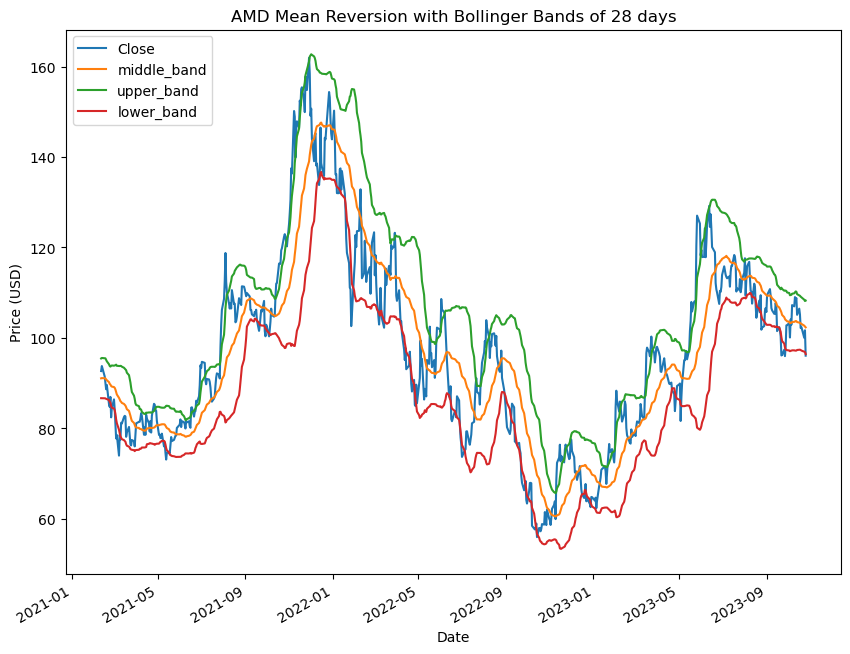

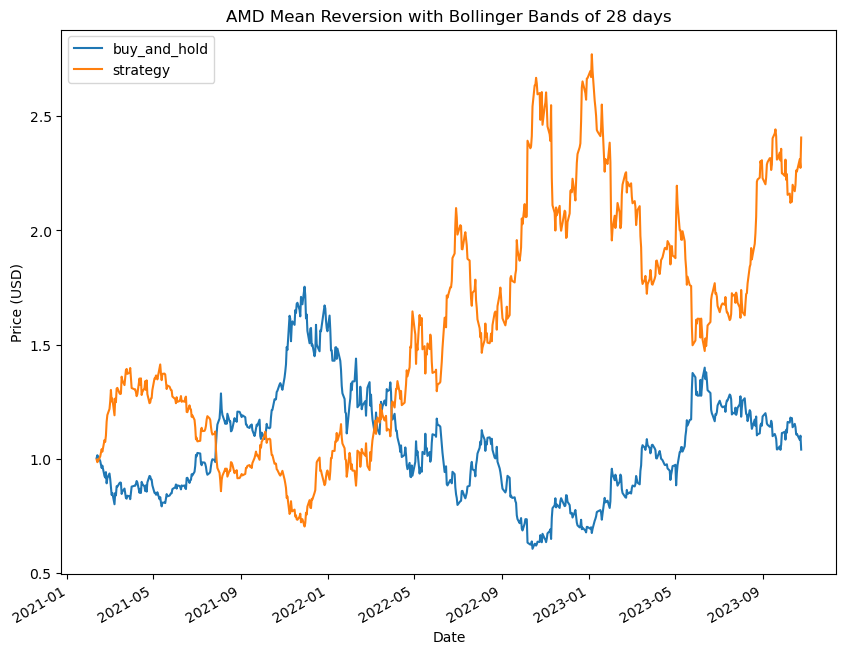

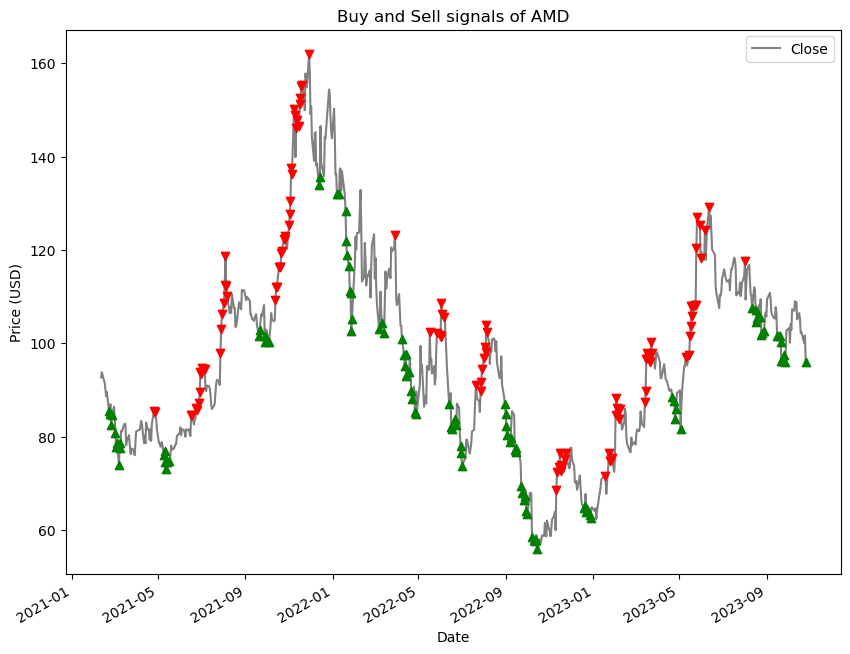

In [6]:
aapl = MeanReversionBollinger("AMD", 28, "2021-01-01")
aapl.performance_summary()

# 3. Mean Reversion with RSI

In [15]:
class MeanReversionRSI():
    
    def __init__(self, symbol, mr_period, rsi_period, start, end=datetime.datetime.now()):
        self.symbol = symbol
        self.mr_period = mr_period
        self.rsi_period = rsi_period
        self.start = start
        self.end = end
        self.get_data()
    
    def get_data(self):

        # extract data
        data = yf.download(self.symbol, start=self.start, end=self.end).loc[:, "Close"].to_frame()

        # calculate rolling mean and standard deviation
        data["rolling_mean"] = data["Close"].rolling(window=self.mr_period).mean()
        data["rolling_std"] = data["Close"].rolling(window=self.mr_period).std()

        # calculate Z-score
        data["Z_score"] = (data["Close"] - data["rolling_mean"]) / data["rolling_std"]

        # calculate RSI
        data.ta.rsi(length = self.rsi_period, close=data["Close"], append=True, append_to_df=True)

        # generate buy and sell signals
        # define entry and exit points
        entry_threshold = -1.5
        exit_threshold = 0.5
        rsi_threshold = 40
        buysignals = data[(data["Z_score"] < entry_threshold) & (data[f"RSI_{self.rsi_period}"] < rsi_threshold)]
        sellsignals = data[(data["Z_score"] > exit_threshold) & (data[f"RSI_{self.rsi_period}"] > 100 - rsi_threshold)]

        # position
        data["position"] = np.where((data["Z_score"] < entry_threshold) & (data[f"RSI_{self.rsi_period}"] < rsi_threshold), 1, -1)

        # buy and hold strategy
        data["buy_and_hold"] = np.log(data["Close"] / data["Close"].shift(1))

        # strategy returns
        data["strategy"] = data["position"].shift(1) * data["buy_and_hold"]

        # drop na
        data.dropna(inplace=True)

        # set date as index
        data.reset_index(inplace=True)
        data.set_index('Date', inplace=True)
        
        # assign to self
        self.data = data
        self.buysignals = buysignals
        self.sellsignals = sellsignals

        return data, buysignals, sellsignals
    
    def performance_summary(self):
            
            # calculate sum of buy_and_hold
            # calculate sum
            print("Sum of returns:")
            print(self.data[["buy_and_hold", "strategy"]].sum(), "\n")
            print("#" * 50)
    
            # calculate what $1 would be worth
            print("What $1 would be worth:")
            print(self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp), "\n")
            print("#" * 50)
    
            # calculate performance metrics
            print("Performance metrics:")
            pf.show_perf_stats(self.data["strategy"])
            print("#" * 50)
    
            # Plot graph
            self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp).plot(figsize=(10, 8))
            plt.legend(loc="upper left")
            plt.title(f"{self.symbol} Mean Reversion with RSI of {self.mr_period} days")
            plt.ylabel("Price (USD)")
            plt.xlabel("Date")
    
            # plot buy and sell signals
            self.data[["Close"]].plot(figsize=(10, 8), color="gray", zorder=1)
            plt.title(f"Buy and Sell signals of {self.symbol}")
            plt.ylabel("Price (USD)")
            plt.xlabel("Date")
    
            plt.scatter(self.buysignals.index, self.buysignals["Close"], marker="^", color="green")
            plt.scatter(self.sellsignals.index, self.sellsignals["Close"], marker="v", color="red")               
    
            plt.legend()
            plt.show()

In [17]:
# Create an empty DataFrame to store the performance statistics
compiled_data = pd.DataFrame()

sp500_tickers = ["AAPL", "AMD", "MSFT", "AMZN", "GOOGL", "JPM", "META", "TSLA", "V", "JNJ",
    "PG", "NVDA", "MA", "HD", "UNH", "VZ", "NFLX", "DIS", "PYPL", "ADBE"]

# Loop through the ticker symbols
for ticker_symbol in sp500_tickers:

    # Instantiate the strategy class with the current ticker symbol
    ticker = MeanReversionRSI(symbol=ticker_symbol,  mr_period = 14, rsi_period=21, start="2022-01-01", end=datetime.datetime.now().date())
    
    # Calculate performance statistics for the strategy
    performance_stats = pf.timeseries.perf_stats(ticker.data["strategy"])
    
    # Create a new row as a DataFrame with the ticker symbol as the index
    new_row = pd.DataFrame([performance_stats], index=[ticker_symbol])
    
    # Concatenate the new row to the compiled_data DataFrame
    compiled_data = pd.concat([compiled_data, new_row], axis=0)

# Rename the columns of the compiled_data DataFrame
compiled_data.columns = [col for col in compiled_data.columns]

# sort the index
compiled_data.sort_index(inplace=True)

# Add average values to the compiled_data DataFrame
average_row = compiled_data.mean()

# Create a new row as a DataFrame
average_row = pd.DataFrame([average_row], index=["average"])

# Concatenate the average_row to the DataFrame
compiled_data = pd.concat([compiled_data, average_row], axis=0)

# round the values
compiled_data = compiled_data.round(3)

# Print the compiled_data DataFrame
compiled_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,Annual return,Cumulative returns,Annual volatility,Sharpe ratio,Calmar ratio,Stability,Max drawdown,Omega ratio,Sortino ratio,Skew,Kurtosis,Tail ratio,Daily value at risk
AAPL,0.052,0.092,0.299,0.319,0.141,0.079,-0.371,1.055,0.467,0.017,1.523,1.228,-0.037
ADBE,0.129,0.232,0.403,0.498,0.260,0.040,-0.495,1.090,0.790,1.061,6.681,1.209,-0.050
AMD,0.061,0.108,0.552,0.383,0.101,0.140,-0.606,1.066,0.555,0.058,1.402,1.061,-0.069
AMZN,0.078,0.139,0.441,0.391,0.174,0.023,-0.449,1.069,0.568,0.090,3.503,1.114,-0.055
DIS,0.377,0.738,0.330,1.133,1.451,0.783,-0.260,1.212,1.786,0.765,4.731,1.046,-0.040
GOOGL,0.216,0.401,0.361,0.721,0.539,0.116,-0.400,1.129,1.057,0.098,1.855,0.979,-0.044
HD,0.116,0.209,0.273,0.538,0.461,0.027,-0.252,1.097,0.832,0.516,3.723,1.058,-0.034
JNJ,0.113,0.202,0.172,0.708,0.811,0.571,-0.139,1.130,1.052,-0.016,3.609,1.139,-0.021
JPM,0.190,0.350,0.261,0.797,0.662,0.150,-0.287,1.144,1.142,-0.309,1.743,1.111,-0.032
MA,-0.048,-0.082,0.257,-0.064,-0.146,0.465,-0.331,0.989,-0.091,-0.002,1.679,1.082,-0.032


In [ ]:
# Export to excel
compiled_data.to_csv('compiled_data_mean_rever_rsi.csv')

[*********************100%***********************]  1 of 1 completed
Sum of returns:
buy_and_hold    0.848751
strategy        0.221635
dtype: float64 

##################################################
What $1 would be worth:
            buy_and_hold  strategy
Date                              
2020-02-03      0.997254  1.002754
2020-02-04      1.030177  0.970707
2020-02-05      1.038577  0.962856
2020-02-06      1.050725  0.951724
2020-02-07      1.033989  0.967128
...                  ...       ...
2023-10-09      2.313205  1.260807
2023-10-10      2.305450  1.265048
2023-10-11      2.323673  1.255127
2023-10-12      2.335433  1.248806
2023-10-13      2.336726  1.248116

[932 rows x 2 columns] 

##################################################
Performance metrics:


Start date,2020-02-03
End date,2023-10-13
Total months,44
,Backtest
Annual return,0.1%
Cumulative returns,0.5%
Annual volatility,34.4%
Sharpe ratio,0.17
Calmar ratio,0.00
Stability,0.22
Max drawdown,-62.3%


##################################################


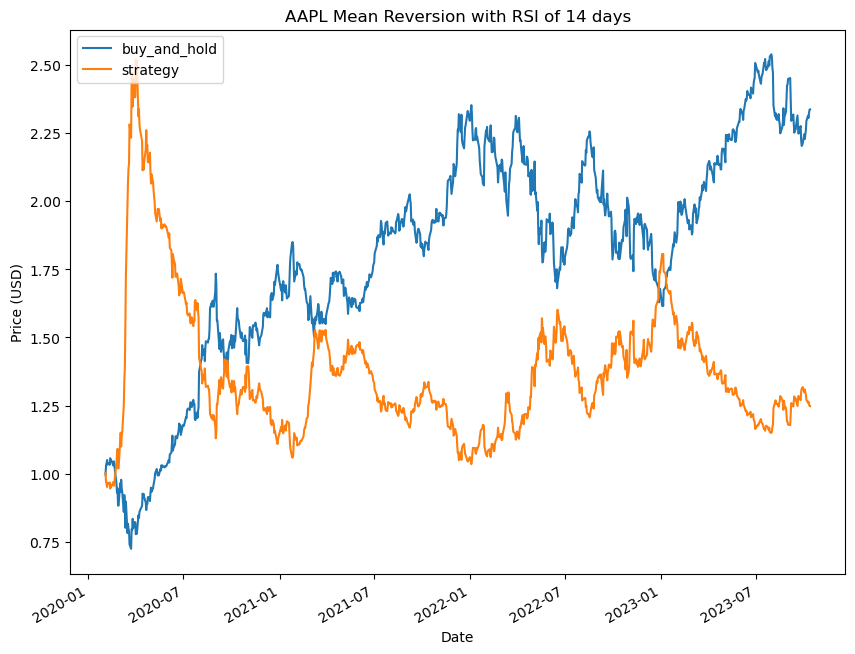

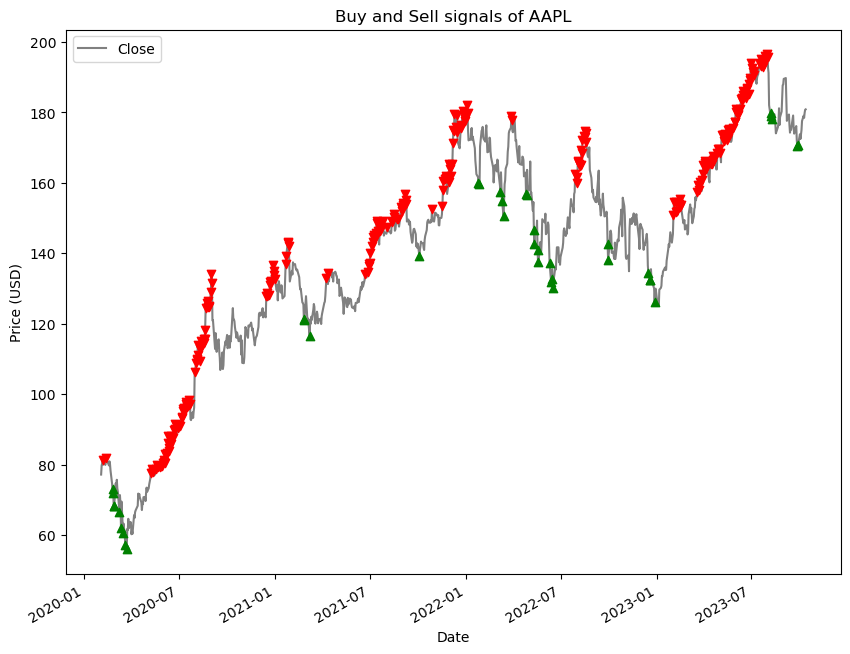

In [55]:
aapl = MeanReversionRSI("AAPL", mr_period=14, rsi_period=21, start="2020-01-01")
aapl.performance_summary()